# Project For Applied Artificial Intellence Class 501: Introduction to AI

## Understanding the Routing Through Urban Areas Using Machine Learning

#### Group 7:

- **Marston S. Ward**
- **Nelson A. Parra**

In [ ]:
# install pacakages not default in Google Colab
! pip install osmnx contextily loguru

In [2]:
# Import global throughout the notebook
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import contextily as ctx
import geopandas as gpd
import networkx as nx
import osmnx as ox

from loguru import logger
from osmnx import routing
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler

### Definitions of functions

In [34]:
def plot_clusters(gdf):
    """
    Visualizes the spatial distribution of clusters from KMeans and
    DBSCAN analysis on a map.

    Each cluster is colored based on the dominant highway type within
    that cluster.

    Args:
        gdf (GeoDataFrame): A GeoDataFrame containing the road network
        edges with 'dbscan_dominant_highway_type' and
        'kmeans_dominant_highway_type' columns.
    """

    logger.info('--- Create the Map Visualization ---')
    # Create two subplots side-by-side for comparison
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

    logger.info('Plot 1: DBSCAN Clusters colored by dominant highway type')
    # Plot the GeoDataFrame on the first subplot (ax1)
    gdf.plot(
        column='dbscan_dominant_highway_type', # Color roads by dominant highway type
        categorical=True,       # Treat dominant highway types as distinct categories
        legend=True,            # Show the legend
        linewidth=2,            # Make lines thicker for better visibility
        ax=ax1,                 # Draw on the first subplot
        cmap='tab10'            # Use a categorical colormap to distinguish highway types
    )
    ax1.set_title('DBSCAN Clusters by Dominant Highway Type')
    ax1.set_axis_off() # Turn off the axes for a cleaner map view
    # Add a basemap for geographical context (requires re-projecting on the fly)
    ctx.add_basemap(ax1, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

    logger.info('Plot 2: KMeans Clusters colored by dominant highway type')
    # Plot the GeoDataFrame on the second subplot (ax2)
    gdf.plot(
        column='kmeans_dominant_highway_type', # Color roads by dominant highway type
        categorical=True,       # Treat dominant highway types as distinct categories
        legend=True,            # Show the legend
        linewidth=2,            # Make lines thicker for better visibility
        ax=ax2,                 # Draw on the second subplot
        cmap='tab10'            # Use a categorical colormap to distinguish highway types
    )
    ax2.set_title('KMeans Clusters by Dominant Highway Type')
    ax2.set_axis_off() # Turn off the axes for a cleaner map view
    # Add a basemap for geographical context
    ctx.add_basemap(ax2, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.show() # Display the plots


def a_star_path_with_penalty(
    G,
    gdf,
    start_point,
    end_point,
    penalty_factor,
    clusterName='kmeans_combined_cluster' # Default to KMeans clusters
    ):
    """
    Finds and visualizes the shortest path between two points in a graph,
    applying a penalty to areas not dominated by residential highways
    based on clustering results.

    This function modifies the edge weights of the graph based on the dominant
    highway type within the cluster each edge belongs to. Edges in clusters
    where the dominant highway is NOT 'residential' have their cost increased
    by the penalty_factor. An A* search is then performed on this modified graph
    to find a path that prioritizes residential areas.

    Args:
        G (networkx.MultiDiGraph): The network graph.
        gdf (GeoDataFrame): A GeoDataFrame containing the graph edges with
        clustering information ('kmeans_combined_cluster' or
        'dbscan_combined_cluster') and dominant highway type columns
        ('kmeans_dominant_highway_type' and 'dbscan_dominant_highway_type').
        start_point (tuple): A tuple (lat, lon) representing the starting point.
        end_point (tuple): A tuple (lat, lon) representing the ending point.
        penalty_factor (float): The factor by which to increase the cost of
        edges in non-residential dominant clusters. A higher value strongly
        discourages using roads in non-residential areas.
        clusterName (str, optional): The name of the column in gdf containing
        the cluster labels to use for applying penalties. Defaults to
        'kmeans_combined_cluster'. Valid options are 'kmeans_combined_cluster'
        and 'dbscan_combined_cluster'.
    """

    # Reset index if it's a MultiIndex, which can happen after some GeoPandas operations
    if isinstance(gdf.index, pd.MultiIndex):
        gdf = gdf.reset_index()

    # Add a new edge attribute for the penalized cost based on the chosen cluster type
    for u, v, key, data in G.edges(keys=True, data=True):
        # Get the base cost, using 'length' attribute if available, otherwise default to 1
        cost = data.get('length', 1)

        # Find the corresponding edge in the GeoDataFrame using u, v, and key
        current_street = gdf[(gdf['u'] == u) & (gdf['v'] == v) & (gdf['key'] == key)]

        # Check if the edge was found in the GeoDataFrame
        if not current_street.empty:
            # Ensure we get the first row if multiple matches exist (shouldn't happen with u,v,key combination)
            current_street = current_street.iloc[0]
            # Get the cluster label for the current edge based on the specified clusterName

            # Determine the column name for the dominant highway type based on the clusterName
            if clusterName == 'kmeans_combined_cluster':
                dominant_type_col = 'kmeans_dominant_highway_type'
            elif clusterName == 'dbscan_combined_cluster':
                dominant_type_col = 'dbscan_dominant_highway_type'
            else:
                # Raise an error if an invalid clusterName is provided
                raise ValueError(f"Invalid clusterName: {clusterName}. Must be 'kmeans_combined_cluster' or 'dbscan_combined_cluster'.")

            # Get the dominant highway type directly from the gdf
            dominant_type = current_street[dominant_type_col]

            # Apply penalty if the dominant type of the cluster is NOT 'residential'
            if dominant_type != 'residential':
                cost *= penalty_factor

        # Determine the key name for the new cost attribute based on the cluster type
        if clusterName == 'kmeans_combined_cluster':
            clusterKey = 'kmeans_cost'
        elif clusterName == 'dbscan_combined_cluster':
            clusterKey = 'dbscan_cost'
        else:
            # This error should theoretically not be reached if the previous check passed
            raise ValueError(f"Invalid clusterName: {clusterName}")

        # Add the calculated penalized cost as a new edge attribute in the graph
        G.edges[u, v, key][clusterKey] = cost

    # Find the nearest network nodes in the graph to the provided start and end points
    start_node = ox.nearest_nodes(G, start_point[1], start_point[0])
    end_node = ox.nearest_nodes(G, end_point[1], end_point[0])

    try:
        # Find the shortest path using the A* algorithm with the newly calculated cost as the weight
        path_nodes_kmeans = nx.astar_path(
            G, start_node, end_node, weight=clusterKey # Use the penalized cost as the weight for pathfinding
            )

        logger.info(f"\nRoute found. Prioritizing residential areas according to {clusterName.split('_')[0]}.")

        # Convert the list of node IDs representing the path to a GeoDataFrame of edges for plotting
        route_gdf_kmeans = routing.route_to_gdf(G, path_nodes_kmeans)

          # Plotting
        fig, ax = plt.subplots(figsize=(12, 12))
        route_gdf_kmeans.plot(ax=ax, linewidth=4, color='orange') # Plot the route in orange with thick lines

        # Add a basemap using contextily for geographical context
        ctx.add_basemap(
            ax,
            crs=route_gdf_kmeans.crs.to_string(), # Ensure basemap CRS matches the route CRS
            source=ctx.providers.OpenStreetMap.Mapnik # Use OpenStreetMap as the basemap source
            )

        # Add a title to the plot indicating which clustering method was used
        if clusterName == 'kmeans_combined_cluster':
          ax.set_title("KMeans A* Shortest Path (Prioritizing Residential)")
        else:
          ax.set_title("DBSCAN A* Shortest Path (Prioritizing Residential)")
        ax.set_axis_off()
        plt.show() # Display the plot
    except nx.NetworkXNoPath:
        # Handle the case where no path can be found between the start and end nodes
        logger.info("\nNo route could be found under the cluster restrictions.")
    except Exception as e:
        # Catch any other potential errors during pathfinding or plotting
        logger.error(f"An error occurred during pathfinding or plotting: {e}")

2025-08-09 21:08:20.084 | INFO     | __main__:<cell line: 0>:10 - Fetching the desired location: Piedmont, California, USA
2025-08-09 21:08:22.094 | INFO     | __main__:<cell line: 0>:12 - Fetched the desired location: Piedmont, California, USA
2025-08-09 21:08:22.095 | INFO     | __main__:<cell line: 0>:13 - Plotting the graph...


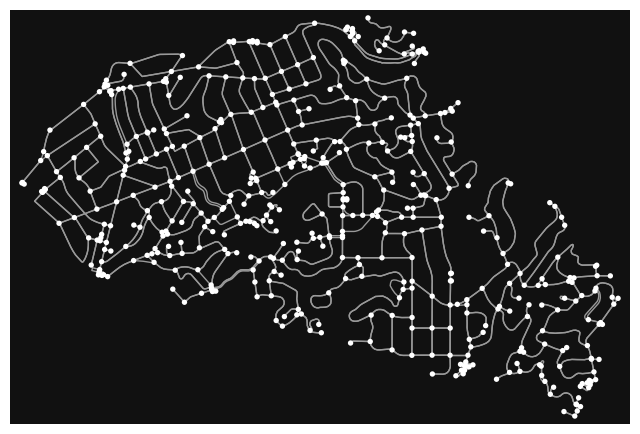

In [24]:
# Increase max query area size (e.g., to 100km * 100km)
# The default is 50km * 50km = 2,500,000,000
#new_max_size = 100000 * 100000  # units are meters
#ox.config(max_query_area_size=new_max_size)

# Choose a location on the level of county. If we go large the graphs become too large to handle efficiently.
location = "Piedmont, California, USA"
transportation_mode = "bike"
# download/model a street network for some city then visualize it
logger.info(f'Fetching the desired location: {location}')
G = ox.graph.graph_from_place(location, network_type=transportation_mode)
logger.info(f'Fetched the desired location: {location}')
logger.info('Plotting the graph...')
fig, ax = ox.plot.plot_graph(G)

In [26]:
logger.info('Get the edges with the information needed to derive a meaningingfull cluster')
edges = ox.graph_to_gdfs(
    G, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True
    )
# Load the graph into a standard geographic CRS
# Standard CRS: https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset#Common_EPSG_codes
logger.info('Load the graph into a standard geographic CRS using geopandas')
standard_crs = "EPSG:4326"
gdf = gpd.GeoDataFrame(edges, crs=standard_crs)

logger.info('Re-project the data to the correct projected CRS and UTM Zone')
# https://www.usgs.gov/faqs/what-does-term-utm-mean-utm-better-or-more-accurate-latitudelongitude
# Get the UTM CRS for the area
utm_crs = gdf.estimate_utm_crs()
logger.info(f"The estimated UTM CRS for Piedmont, California, USA is: {utm_crs}")
gdf_proj = gdf.to_crs("EPSG:32610")

# We are finding the central point of each individual road line or polygon.
# These central points are then used for clustering, as they provide a single
# coordinate (x, y) to represent the location of each road segment.
logger.info('Find the centroids that represents the geometric center of each edge')
centroids = gdf_proj.geometry.centroid
coords = pd.DataFrame({'x': centroids.x, 'y': centroids.y})

# Use 'highway' column by converting them to strings and use them for clustering
gdf['highway'] = gdf['highway'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# One-Hot Encode the 'highway' column
highway_onehot = pd.get_dummies(gdf['highway'], prefix='highway')
# Combine coordinates and encoded columns into a single feature set
# We reset the index to prevent alignment issues
features = pd.concat([coords.reset_index(drop=True), highway_onehot.reset_index(drop=True)], axis=1)
# Scale the combined features so coordinates don't dominate
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# --- Clustering ---
# NOTE: Parameters must be re-tuned as 'eps' is no longer in meters.
db = DBSCAN(eps=1.5, min_samples=5).fit(features_scaled)
gdf['dbscan_combined_cluster'] = db.labels_

kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto').fit(features_scaled)
gdf['kmeans_combined_cluster'] = kmeans.labels_
# The new cluster labels are now in your GeoDataFrame, ready for visualization
gdf[['highway', 'kmeans_combined_cluster']].head()
# note GDF keys: u, v, key, highway, kmeans_combined_cluster

2025-08-09 21:12:45.221 | INFO     | __main__:<cell line: 0>:1 - Get the edges with the information needed to derive a meaningingfull cluster
2025-08-09 21:12:45.246 | INFO     | __main__:<cell line: 0>:7 - Load the graph into a standard geographic CRS using geopandas
2025-08-09 21:12:45.248 | INFO     | __main__:<cell line: 0>:11 - Re-project the data to the correct projected CRS and UTM Zone
2025-08-09 21:12:45.356 | INFO     | __main__:<cell line: 0>:15 - The estimated UTM CRS for Piedmont, California, USA is: EPSG:32610
2025-08-09 21:12:45.363 | INFO     | __main__:<cell line: 0>:21 - Find the centroids that represents the geometric center of each edge


highway  kmeans_combined_cluster
u        v        key                                      
53017091 53064327 0    residential                        1
         53075599 0    residential                        1
53018397 53018399 0    residential                        1
         53018411 0       tertiary                        3
         53097980 0       tertiary                        3

# Next Step
We used both methods just to test them. Here are the results:  
Both methods are clustering the exact same input data, but they are producing very different outputs because their clustering logic is fundamentally different.

## Key Differences

| Feature             | DBSCAN                                                                 | KMeans                                                                 |
|---------------------|------------------------------------------------------------------------|------------------------------------------------------------------------|
| Input Data          | Acts on the (x, y) coordinates of the road centroids                   | Acts on the exact same (x, y) coordinates of the road centroids       |
| How it Works        | Density-based. Groups points that are closely packed together, marking points in low-density regions as noise. Finds clusters based on a search radius (eps) | Centroid-based. Partitions data into a specified number (k) of clusters, where each point belongs to the cluster with the nearest mean (centroid)                                       |
| Number of Clusters  | Determined automatically based on data density. In this case, it found 25 clusters  | Must be specified beforehand. n_clusters=10, so it was forced to create exactly 10 clusters |
| Cluster Shape       | Can find arbitrarily shaped clusters                                  | Tends to create roughly spherical, evenly-sized clusters              |


THe visualizations below illustrate the difference between the two algorithms:

- **KMeans:** This method partitioned the map into 10 large, distinct zones. Because k=10, it divided all the road segments among those 10 groups, with each group centered around a calculated point. This is useful for tasks like creating 10 service districts or sales territories.

- **DBSCAN:** This method finds clusters, in this case 25. It didn't try to
assign every single road to a large zone. Instead, it identified tight,
local groupings. This is useful for identifying distinct neighborhoods or
areas of dense development.

While they both started with the same location data, KMeans answered
"How can I split this map into 10 zones?" while DBSCAN answered
"Where are the dense clusters of roads on this map?"

This is not what we want. We want: both methods to cluster the highway column to id where these categories in the map.
We have to a form of one-hot-coding on `highway`

## Determine highway type

In [31]:
logger.info('Find dominant highway type for each KMeans cluster')
kmeans_dominant_highway = {}
for cluster_label in gdf['kmeans_combined_cluster'].unique():
    cluster_gdf = gdf[gdf['kmeans_combined_cluster'] == cluster_label]
    # Use .mode()[0] to get the first mode in case of ties
    dominant_highway = cluster_gdf['highway'].mode()
    if not dominant_highway.empty:
        kmeans_dominant_highway[cluster_label] = dominant_highway[0]
    else:
        kmeans_dominant_highway[cluster_label] = None # Handle empty clusters

logger.info('Find dominant highway type for each DBSCAN cluster')
dbscan_dominant_highway = {}
for cluster_label in gdf['dbscan_combined_cluster'].unique():
    cluster_gdf = gdf[gdf['dbscan_combined_cluster'] == cluster_label]
    dominant_highway = cluster_gdf['highway'].mode()
    if not dominant_highway.empty:
        dbscan_dominant_highway[cluster_label] = dominant_highway[0]
    else:
        dbscan_dominant_highway[cluster_label] = None # Handle empty clusters

logger.info(f"KMeans Dominant Highway Types per Cluster: {kmeans_dominant_highway}")
logger.info("DBSCAN Dominant Highway Types per Cluster:  {dbscan_dominant_highway}")

2025-08-09 21:26:24.885 | INFO     | __main__:<cell line: 0>:1 - Find dominant highway type for each KMeans cluster
2025-08-09 21:26:24.898 | INFO     | __main__:<cell line: 0>:12 - Find dominant highway type for each DBSCAN cluster
2025-08-09 21:26:24.905 | INFO     | __main__:<cell line: 0>:22 - KMeans Dominant Highway Types per Cluster: {np.int32(1): 'residential', np.int32(3): 'tertiary', np.int32(8): 'residential', np.int32(0): 'residential', np.int32(4): 'secondary', np.int32(2): 'service', np.int32(5): 'unclassified', np.int32(9): 'path', np.int32(6): 'tertiary_link', np.int32(7): 'residential, service'}
2025-08-09 21:26:24.905 | INFO     | __main__:<cell line: 0>:23 - DBSCAN Dominant Highway Types per Cluster:  {dbscan_dominant_highway}


## Map cluster labels to dominant highway types

In [32]:
logger.info('Map KMeans cluster labels to dominant highway types')
gdf['kmeans_dominant_highway_type'] = gdf['kmeans_combined_cluster'].map(kmeans_dominant_highway)

logger.info('Map DBSCAN cluster labels to dominant highway types')
gdf['dbscan_dominant_highway_type'] = gdf['dbscan_combined_cluster'].map(dbscan_dominant_highway)

# Display the first few rows including the new columns
logger.info(gdf[['highway', 'kmeans_combined_cluster', 'kmeans_dominant_highway_type', 'dbscan_combined_cluster', 'dbscan_dominant_highway_type']].head())

2025-08-09 21:34:39.406 | INFO     | __main__:<cell line: 0>:1 - Map KMeans cluster labels to dominant highway types
2025-08-09 21:34:39.408 | INFO     | __main__:<cell line: 0>:4 - Map DBSCAN cluster labels to dominant highway types
2025-08-09 21:34:39.411 | INFO     | __main__:<cell line: 0>:8 -                            highway  kmeans_combined_cluster  \
u        v        key                                         
53017091 53064327 0    residential                        1   
         53075599 0    residential                        1   
53018397 53018399 0    residential                        1   
         53018411 0       tertiary                        3   
         53097980 0       tertiary                        3   

                      kmeans_dominant_highway_type  dbscan_combined_cluster  \
u        v        key                                                         
53017091 53064327 0                    residential                        0   
         53075599 0   

**Reasoning**:
Call the modified plot_clusters function to visualize the clusters colored by dominant highway type.



2025-08-09 21:34:41.942 | INFO     | __main__:plot_clusters:15 - --- Create the Map Visualization ---
2025-08-09 21:34:41.956 | INFO     | __main__:plot_clusters:19 - Plot 1: DBSCAN Clusters colored by dominant highway type
2025-08-09 21:34:42.481 | INFO     | __main__:plot_clusters:34 - Plot 2: KMeans Clusters colored by dominant highway type


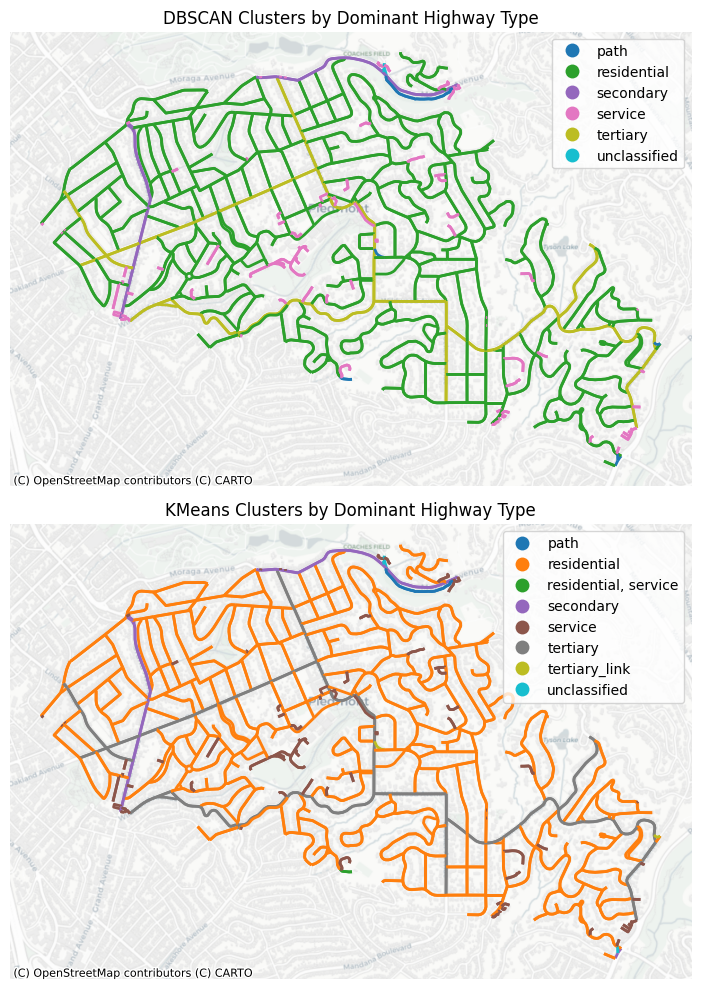

In [33]:
plot_clusters(gdf)

## Summary:

### Data Analysis Key Findings

*   For KMeans clusters, the dominant highway types were identified for each cluster label. For example, cluster 1 is dominated by 'residential' highways.
*   For DBSCAN clusters, the dominant highway types were also determined. Cluster 0 is dominated by 'residential' highways, while the noise cluster (-1) is dominated by `path` highways. The `path` category corresponds to `unclassified` in the other method.


2025-08-09 19:55:16.826 | INFO     | __main__:a_star_path_with_penalty:144 - 
Route found. Prioritizing residential areas according to kmeans.


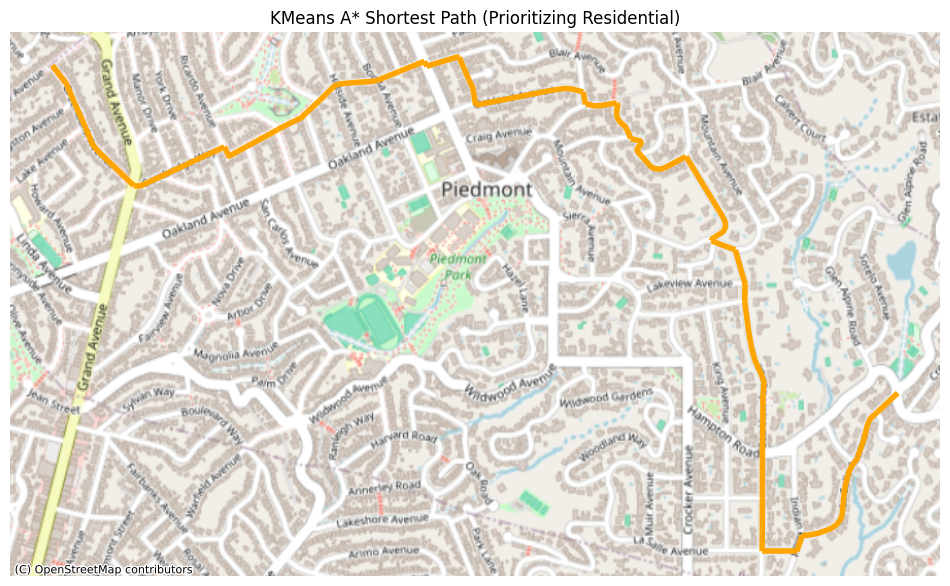

2025-08-09 19:55:18.610 | INFO     | __main__:a_star_path_with_penalty:144 - 
Route found. Prioritizing residential areas according to dbscan.


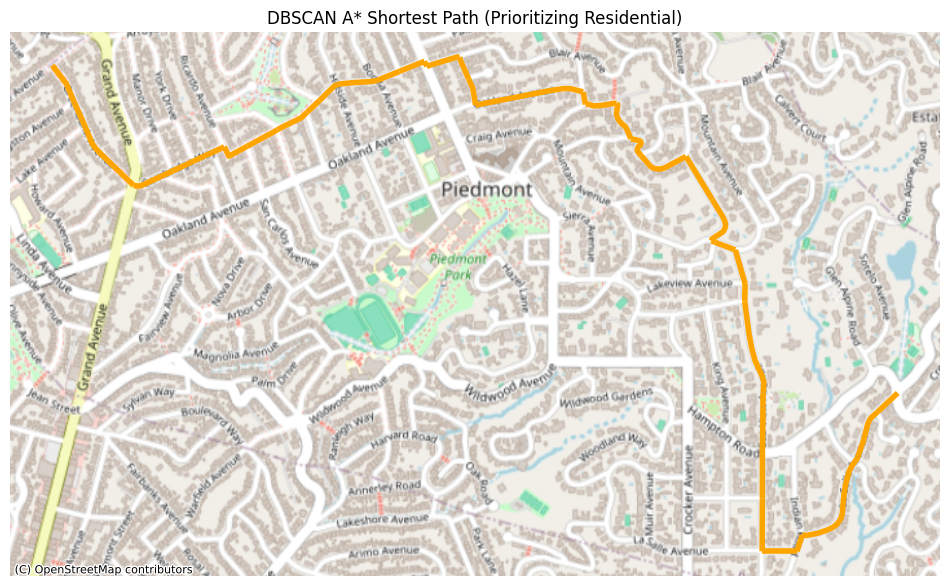

In [20]:
start_point = (37.827537, -122.245535)
end_point = (37.819275, -122.218562)
penalty_factor = 10
cname = 'kmeans_combined_cluster'
a_star_path_with_penalty(G, gdf, start_point, end_point, penalty_factor, clusterName='kmeans_combined_cluster')
cname = 'dbscan_combined_cluster'
a_star_path_with_penalty(G, gdf, start_point, end_point, penalty_factor, clusterName='dbscan_combined_cluster')

# Sensitivity Study of the Penalty Factor

2025-08-09 22:30:26.087 | INFO     | __main__:<cell line: 0>:3 - Penalty factors: [1, 50]
2025-08-09 22:30:26.089 | INFO     | __main__:<cell line: 0>:6 - Testing with Penalty Factor: 1
2025-08-09 22:30:26.089 | INFO     | __main__:<cell line: 0>:8 - --- KMeans Clusters ---
2025-08-09 22:30:27.257 | INFO     | __main__:a_star_path_with_penalty:144 - 
Route found. Prioritizing residential areas according to kmeans.


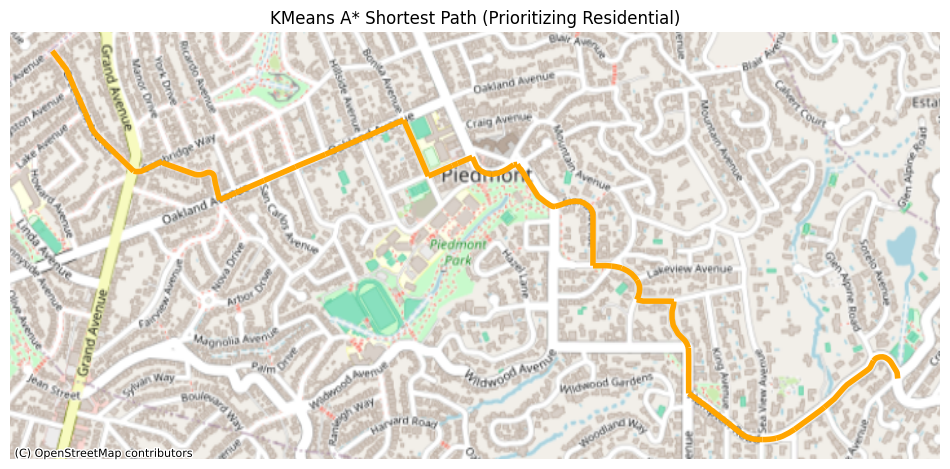

2025-08-09 22:30:27.779 | INFO     | __main__:<cell line: 0>:18 - --- DBSCAN Clusters ---
2025-08-09 22:30:28.949 | INFO     | __main__:a_star_path_with_penalty:144 - 
Route found. Prioritizing residential areas according to dbscan.


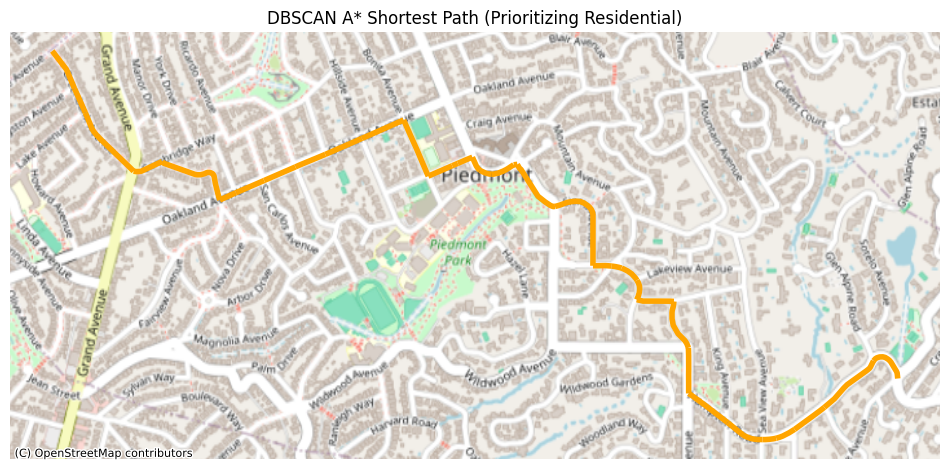

2025-08-09 22:30:29.464 | INFO     | __main__:<cell line: 0>:6 - Testing with Penalty Factor: 50
2025-08-09 22:30:29.464 | INFO     | __main__:<cell line: 0>:8 - --- KMeans Clusters ---
2025-08-09 22:30:30.629 | INFO     | __main__:a_star_path_with_penalty:144 - 
Route found. Prioritizing residential areas according to kmeans.


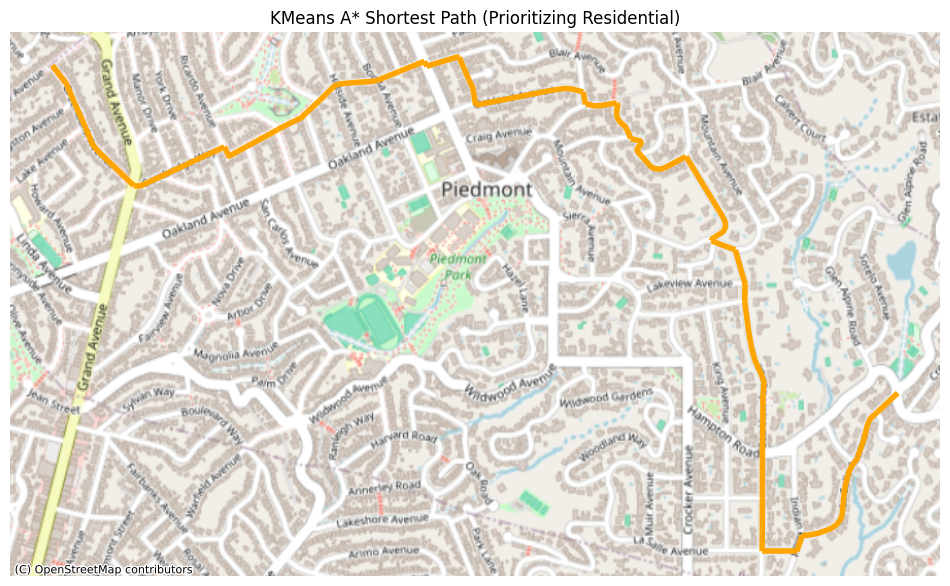

2025-08-09 22:30:31.222 | INFO     | __main__:<cell line: 0>:18 - --- DBSCAN Clusters ---
2025-08-09 22:30:32.410 | INFO     | __main__:a_star_path_with_penalty:144 - 
Route found. Prioritizing residential areas according to dbscan.


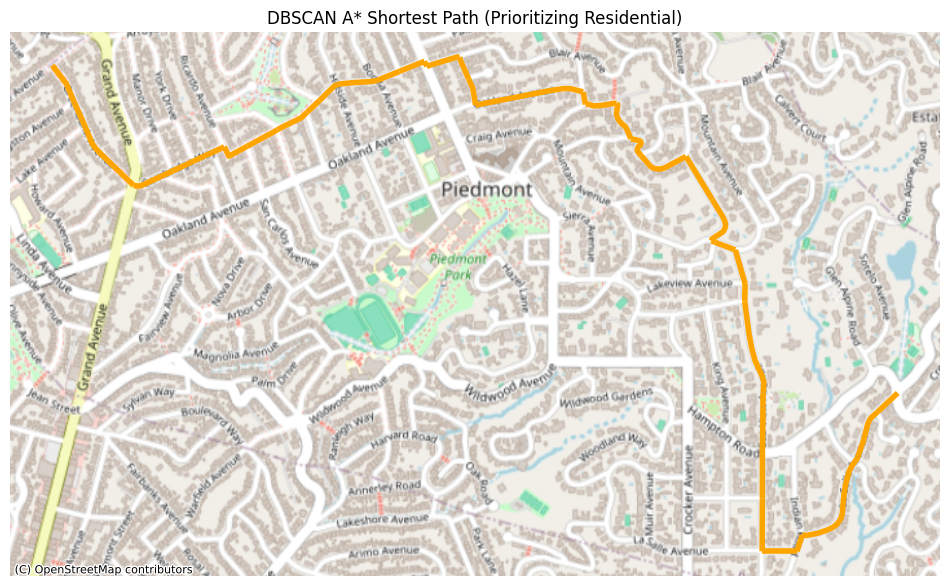

In [36]:
# Define a range of penalty factors to test
penalty_factors = [1, 50]
logger.info(f"Penalty factors: {penalty_factors}")

for penalty_factor in penalty_factors:
    logger.info(f"Testing with Penalty Factor: {penalty_factor}")

    logger.info("--- KMeans Clusters ---")
    a_star_path_with_penalty(
        G,
        gdf,
        start_point,
        end_point,
        penalty_factor,
        clusterName='kmeans_combined_cluster'
    )

    logger.info("--- DBSCAN Clusters ---")
    a_star_path_with_penalty(
        G,
        gdf,
        start_point,
        end_point,
        penalty_factor,
        clusterName='dbscan_combined_cluster'
    )

## Quantify the effect of the penalty factor by calculating route distances

In [37]:
logger.info("Calculating route distances for different penalty factors...")

route_distances = {}

start_node = ox.nearest_nodes(G, start_point[1], start_point[0])
end_node = ox.nearest_nodes(G, end_point[1], end_point[0])

for penalty_factor in penalty_factors:
    logger.info(f"\n--- Penalty Factor: {penalty_factor} ---")

    # KMeans
    cluster_key_kmeans = 'kmeans_cost'
    try:
        path_nodes_kmeans = nx.astar_path(G, start_node, end_node, weight=cluster_key_kmeans)
        route_gdf_kmeans = routing.route_to_gdf(G, path_nodes_kmeans)
        route_length_kmeans = route_gdf_kmeans['length'].sum()
        route_distances[(penalty_factor, 'kmeans')] = route_length_kmeans
        logger.info(f"KMeans Route Distance: {route_length_kmeans:.2f} meters")
    except nx.NetworkXNoPath:
        route_distances[(penalty_factor, 'kmeans')] = None
        logger.info("KMeans: No route found.")
    except Exception as e:
        logger.error(f"An error occurred during KMeans pathfinding: {e}")
        route_distances[(penalty_factor, 'kmeans')] = None


    # DBSCAN
    cluster_key_dbscan = 'dbscan_cost'
    try:
        path_nodes_dbscan = nx.astar_path(G, start_node, end_node, weight=cluster_key_dbscan)
        route_gdf_dbscan = routing.route_to_gdf(G, path_nodes_dbscan)
        route_length_dbscan = route_gdf_dbscan['length'].sum()
        route_distances[(penalty_factor, 'dbscan')] = route_length_dbscan
        logger.info(f"DBSCAN Route Distance: {route_length_dbscan:.2f} meters")
    except nx.NetworkXNoPath:
        route_distances[(penalty_factor, 'dbscan')] = None
        logger.info("DBSCAN: No route found.")
    except Exception as e:
        logger.error(f"An error occurred during DBSCAN pathfinding: {e}")
        route_distances[(penalty_factor, 'dbscan')] = None

logger.info("\nSummary of Route Distances:")
for (penalty, cluster_method), distance in route_distances.items():
    if distance is not None:
        logger.info(f"Penalty Factor {penalty}, {cluster_method} Cluster: {distance:.2f} meters")
    else:
        logger.info(f"Penalty Factor {penalty}, {cluster_method} Cluster: No route found")

2025-08-09 22:33:41.030 | INFO     | __main__:<cell line: 0>:1 - Calculating route distances for different penalty factors...
2025-08-09 22:33:41.040 | INFO     | __main__:<cell line: 0>:9 - 
--- Penalty Factor: 1 ---
2025-08-09 22:33:41.052 | INFO     | __main__:<cell line: 0>:18 - KMeans Route Distance: 4249.99 meters
2025-08-09 22:33:41.064 | INFO     | __main__:<cell line: 0>:34 - DBSCAN Route Distance: 4249.99 meters
2025-08-09 22:33:41.064 | INFO     | __main__:<cell line: 0>:9 - 
--- Penalty Factor: 5 ---
2025-08-09 22:33:41.076 | INFO     | __main__:<cell line: 0>:18 - KMeans Route Distance: 4249.99 meters
2025-08-09 22:33:41.088 | INFO     | __main__:<cell line: 0>:34 - DBSCAN Route Distance: 4249.99 meters
2025-08-09 22:33:41.089 | INFO     | __main__:<cell line: 0>:9 - 
--- Penalty Factor: 10 ---
2025-08-09 22:33:41.100 | INFO     | __main__:<cell line: 0>:18 - KMeans Route Distance: 4249.99 meters
2025-08-09 22:33:41.111 | INFO     | __main__:<cell line: 0>:34 - DBSCAN Rout